Assignment by Abhijit Kshirsagar

Install dependencies

In [1]:
!pip install -q tensorflow tensorflow-datasets keras-tuner scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00


Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds

Load EMNIST Dataset
**Advanced Bonus Features 1:Train on EMNIST (letters + digits)**

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features['label'].num_classes  # 62: 10 digits + 52 letters

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.ROGHFY_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.ROGHFY_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.


Normalize and Preprocess functions


In [4]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.transpose(image)
    image = tf.expand_dims(image, -1)      #Adding channel dim
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

ds_train = ds_train.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

Define Model

In [5]:
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(28, 28, 1)))

    model.add(layers.Conv2D(
        filters=hp.Int('conv1_filters', 32, 64, step=16),
        kernel_size=3,
        activation='relu'
    ))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(
        filters=hp.Int('conv2_filters', 64, 128, step=32),
        kernel_size=3,
        activation='relu'
    ))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))

    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', 128, 256, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout2', 0.3, 0.6, step=0.1)))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Hyperparameter tuning with Keras Tuner
**Advanced bonus features 2: Hyperparameter tuning (GridSearch/Keras Tuner)**

In [6]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=3,
    factor=3,
    directory='emnist_tuner',
    project_name='emnist_cnn'
)

**Advanced bonus features 3: Early stopping and model checkpointing**

In [7]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_emnist_model.h5', save_best_only=True, monitor='val_accuracy')

Running Tuner

In [8]:
tuner.search(ds_train, epochs=3, validation_data=ds_test,
             callbacks=[early_stop, checkpoint], verbose=2)

Trial 6 Complete [00h 04m 05s]
val_accuracy: 0.857319712638855

Best val_accuracy So Far: 0.8632428646087646
Total elapsed time: 00h 18m 56s


Model Training

In [9]:
best_model = tuner.get_best_models(1)[0]

history = best_model.fit(
    ds_train,
    epochs=15,
    validation_data=ds_test,
    callbacks=[early_stop, checkpoint],
    verbose=2
)

Epoch 1/15


5453/5453 - 89s - 16ms/step - accuracy: 0.8524 - loss: 0.4171 - val_accuracy: 0.8663 - val_loss: 0.3679
Epoch 2/15


5453/5453 - 80s - 15ms/step - accuracy: 0.8568 - loss: 0.3988 - val_accuracy: 0.8675 - val_loss: 0.3640
Epoch 3/15
5453/5453 - 81s - 15ms/step - accuracy: 0.8600 - loss: 0.3857 - val_accuracy: 0.8666 - val_loss: 0.3678
Epoch 4/15


5453/5453 - 80s - 15ms/step - accuracy: 0.8628 - loss: 0.3758 - val_accuracy: 0.8688 - val_loss: 0.3600
Epoch 5/15
5453/5453 - 79s - 15ms/step - accuracy: 0.8651 - loss: 0.3669 - val_accuracy: 0.8672 - val_loss: 0.3628
Epoch 6/15
5453/5453 - 80s - 15ms/step - accuracy: 0.8665 - loss: 0.3602 - val_accuracy: 0.8681 - val_loss: 0.3599
Epoch 7/15
5453/5453 - 78s - 14ms/step - accuracy: 0.8684 - loss: 0.3535 - val_accuracy: 0.8684 - val_loss: 0.3633
Epoch 8/15
5453/5453 - 79s - 14ms/step - accuracy: 0.8705 - loss: 0.3474 - val_accuracy: 0.8680 - val_loss: 0.3700
Epoch 9/15


5453/5453 - 92s - 17ms/step - accuracy: 0.8714 - loss: 0.3429 - val_accuracy: 0.8693 - val_loss: 0.3675


Evaluation, Classification report and Confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━

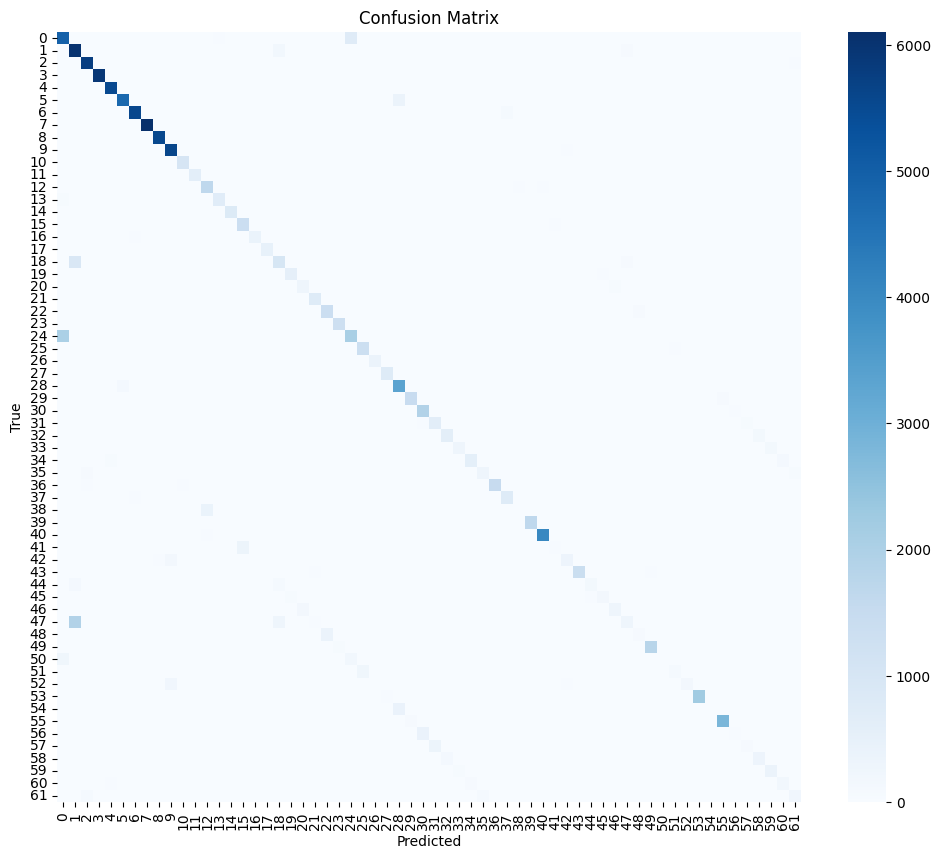

In [10]:
#Evaluation
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Classification Report
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="Blues", xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()